#  Twitter Sentiment Analysis Notebook
This notebook performs:
- Data loading
- Text preprocessing
- Lexicon-based sentiment analysis using VADER
- Machine learning-based sentiment analysis (Naive Bayes)
- Evaluation of models

In [2]:
# Load Libraries
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aakas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aakas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aakas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
#  Load Dataset
df = pd.read_csv('twitter_training.csv', header=None)
df.columns = ['ID', 'Topic', 'Sentiment', 'Tweet']
df = df[df['Sentiment'] != 'Irrelevant']  # Optional: Remove irrelevant labels
df = df.reset_index(drop=True)
df.head()

,ID,Topic,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


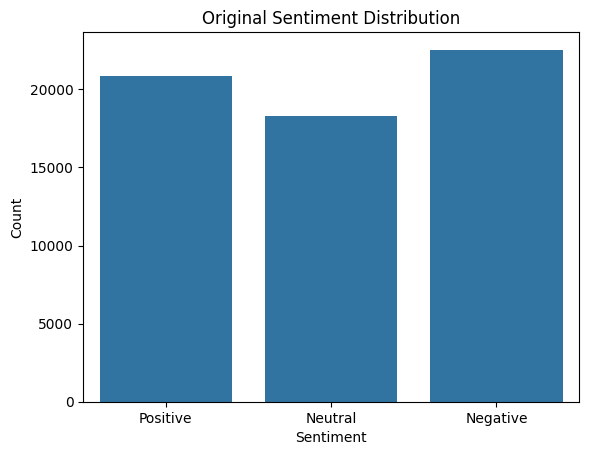

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x='Sentiment')
plt.title('Original Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


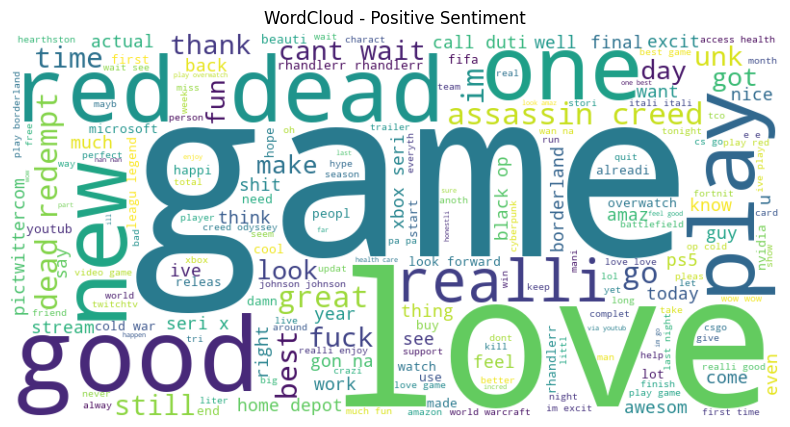

In [8]:
from wordcloud import WordCloud

positive_words = ' '.join(df[df['Sentiment'] == 'Positive']['Processed'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Positive Sentiment')
plt.show()


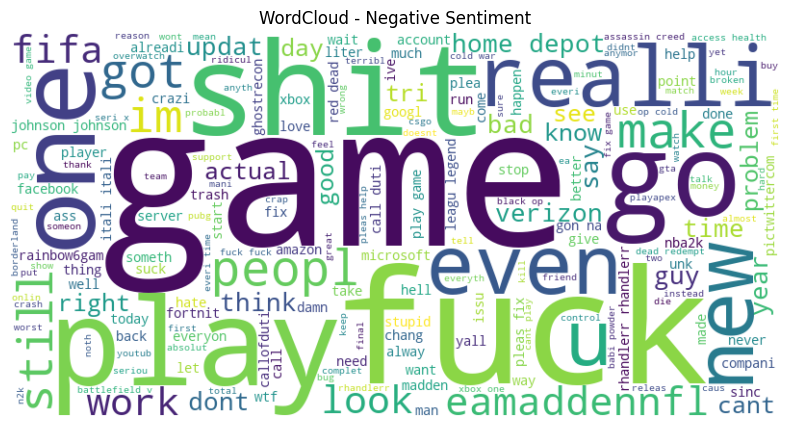

In [9]:
negative_words = ' '.join(df[df['Sentiment'] == 'Negative']['Processed'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Negative Sentiment')
plt.show()


##  Preprocessing Tweets

In [10]:
df['Tweet'] = df['Tweet'].astype(str)  # Force all tweets to be strings

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Processed'] = df['Tweet'].apply(preprocess)
df[['Tweet', 'Processed']].head()

,Tweet,Processed
0,im getting on borderlands and i will murder yo...,im get borderland murder
1,I am coming to the borders and I will kill you...,come border kill
2,im getting on borderlands and i will kill you ...,im get borderland kill
3,im coming on borderlands and i will murder you...,im come borderland murder
4,im getting on borderlands 2 and i will murder ...,im get borderland 2 murder


##  Lexicon-Based Sentiment Analysis using VADER

In [11]:
sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['VADER_Sentiment'] = df['Tweet'].apply(vader_sentiment)
df[['Tweet', 'Sentiment', 'VADER_Sentiment']].head()

,Tweet,Sentiment,VADER_Sentiment
0,im getting on borderlands and i will murder yo...,Positive,Negative
1,I am coming to the borders and I will kill you...,Positive,Negative
2,im getting on borderlands and i will kill you ...,Positive,Negative
3,im coming on borderlands and i will murder you...,Positive,Negative
4,im getting on borderlands 2 and i will murder ...,Positive,Negative


##  ML-Based Sentiment Classifier using Naive Bayes
# Encode target


In [12]:
from sklearn.pipeline import Pipeline

label_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['SentimentEncoded'] = df['Sentiment'].map(label_map)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    df['Processed'], df['SentimentEncoded'], test_size=0.2, random_state=42)

# Build model pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# Train
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[3784  258  467]
 [ 680 2281  689]
 [ 582  212 3386]]
              precision    recall  f1-score   support

          -1       0.75      0.84      0.79      4509
           0       0.83      0.62      0.71      3650
           1       0.75      0.81      0.78      4180

    accuracy                           0.77     12339
   macro avg       0.77      0.76      0.76     12339
weighted avg       0.77      0.77      0.76     12339

